# CNN: DogsCats DataSet 

Today 

1. Download raw data and structure the large data into train and test dataset using terminal on SageMaker-AWS

2. Format images in a format ready for training in SageMaker 

3. Transfer learning

**Note: My code is designed for Tensorflow 2.1.0.** 
- Please use conda_tensorflow2_p36 as the kernel. 

- To do that, you need to select **notebook-a11-v1** under platform identifier when creating a notebook instance. I use EC2 instance ml.t3.medium for notebook. 

- If you use different tensforflow version, you will need to adjust the code. 






### Data

Data in this exercise are about dogs and cats images from https://www.kaggle.com/c/dogs-vs-cats. The data is about 1GB.

**Tasks**

1. Download [data from kaggle](https://www.kaggle.com/c/dogs-vs-cats). You will need to have made a kaggle account if you don't already have one. 
 
2. There are three options for obtaining data from Kaggle 
     - **OPTION 1**: Using the Kaggle API -we download a large data directly from a website to AWS SageMaker. Instructions can be found [here](https://github.com/Kaggle/kaggle-api) and [here](https://freddiek.github.io/2018/06/10/accessing-Kaggle-from-SageMaker-instance.html). 

     - **OPTION 2**: We can download it straight to a SageMake notebook instance using the CurlWget chrome extension and wget as shown [here](https://www.kaggle.com/c/deepfake-detection-challenge/discussion/129521) 
     
     - **OPTION 3**: Download the to our local machine and then upload it to notebook instance (Note: it is not an ideal, especially for large datasets. Use this approach if you have a trouble to get Kaggle API). 

**Here I am using option 1. The following code run on SageMaker Terminal, which can be accessed via JupyterLab**


After you have collected your images, we will 
1. Sort by dataset, such as train, test, and validation, and;

2. Sort them by their classes. 

    - Note 1: Remember how we loaded the mnist_fashion data - this is one of the ways that data is structured behind the scenes. 
    - Note 2: or small dataset, you can do this in your local machine, as explained [here by Jason Brownlee]
(https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/).

In this example, we wish to classify dogs and cats. 

First, we have a `data/` directory where we will store all of the images of dogs and cats in the dataset.

Next, we will have a `data/train/` directory for the training dataset and a `data/test/` for the holdout test dataset. We may also have a `data/validation/` for a validation dataset during training.

We are going to perform this process using AWS SageMaker Terminal. We aim to achieve the following  

In [1]:
!sudo chown ec2-user lost+found
!sudo chgrp ec2-user lost+found

In [2]:
ls -l

total 1384
drwx------ 2 ec2-user ec2-user   16384 Sep 21 18:51 lost+found/
-rw-rw-r-- 1 ec2-user ec2-user 1396077 Sep 21 18:55 MA3832_W9_CNN2(1).ipynb
drwxrwxr-x 3 ec2-user ec2-user    4096 Sep 21 18:57 train/


The dog and cat images are mixed up in the same folder. Therefore we create a subfolder for each class and move the appropriate images into each folder

**The following code is used on the terminal**

In [ ]:

#unzip data folder
unzip dogs-vs-cats.zip
#unzip training data
unzip train.zip

In [ ]:
cd train # move into training folder
mkdir dog cat # creating directories 
mv cat.* cat/ # move all cat images to cat directory
mv dog.* dog/ # move all dog images to dog directory

We are now going to generate our own validation set to evaluate the performace of the model containing 1000 dog images and 1000 cat images (not we could have used to in-built test set, but this is to practice generating your own).

We are going to generate 1000 random dog images and 1000 random cat images to specific directories.

In [ ]:
cd ..
mkdir -p val/dog val/cat #make dog and cat directories in val
ls train/dog | sort -R |tail -1000 | while read file; do mv train/dog/$file val/dog; done
ls train/cat | sort -R |tail -1000 | while read file; do mv train/cat/$file val/cat; done

Take a look at the entire dataset

In [ ]:
du -h

### upload to S3 bucket
Please check that only 2 folders **train, val** are uploaded in S3 bucket. 

!!! Remember to select your S3 bucket directory

### CNN


In [1]:

import sagemaker
# define environment variables
sess = sagemaker.Session()
role = sagemaker.get_execution_role()  
bucket = sess.default_bucket()


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
import os
import itertools
import numpy as np
from sagemaker.tensorflow import TensorFlow
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D

print("Tensorflow ver: " + tf.__version__) 

Tensorflow ver: 2.6.2


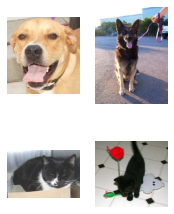

In [3]:
# take a look at a couple of images from both classes
dog_img_path = './train/dog/'
cat_img_path = './train/cat/'


for i in range(1,3):
    plt.subplot(240 + i)
    filename = dog_img_path + 'dog.200' + str(i) + '.jpg'   
    img = imread(filename)
    plt.imshow(img)
    plt.axis("off")
    
for i in range(1,3):
    plt.subplot(244 + i)
    filename = cat_img_path + 'cat.200' + str(i) + '.jpg'   
    img = imread(filename)
    plt.imshow(img)
    plt.axis("off")

For the demonstration, I scale image pixels down to 25x25. Please keep in mind that the tradeoff will be between computation time and accuracy. 

In [4]:
training_local_path = './train/'
validation_local_path = './val/'
graph_path = os.makedirs("./output/graph/", exist_ok=True)
datagen = ImageDataGenerator(rescale=1.0/255.0)
img_cols = 25
img_rows = 25
    
train_batches = datagen.flow_from_directory(training_local_path , class_mode='binary',
                                            target_size=(img_rows, img_cols))
val_batches = datagen.flow_from_directory(validation_local_path , class_mode='binary',
                                              target_size=(img_rows, img_cols))

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [6]:
X_train = train_batches[0][0]
y_train = train_batches[0][1]
X_val = val_batches[0][0]
y_val = val_batches[0][1]

In [7]:

print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)

print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)

X_train shape: (32, 25, 25, 3)
X_val shape: (32, 25, 25, 3)
y_train shape: (32,)
y_val shape: (32,)


In [28]:

input_shape = (img_rows, img_cols, 3)


In [29]:
model = tf.keras.Sequential()
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(img_rows, img_cols, 3)))
## downsample using a max pooling layer, which feeds into the next set of convolutional layers
model.add(MaxPooling2D(pool_size=(2,2)))
## 2nd convolultion layer
## convolutional layer with 32 filters
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# flatten and classify
## flattern spacial information into a vector, and learn the final probability distribution for each class
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 23, 23, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 32)          18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                16416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0

In [30]:
train_model = model.fit(train_batches, validation_data=val_batches, epochs=2, steps_per_epoch=len(train_batches),
                        validation_steps=len(val_batches), verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 719 steps, validate for 63 steps
Epoch 1/2
719/719 [==============================] - 67s 92ms/step - loss: 0.6583 - accuracy: 0.5923 - val_loss: 0.5971 - val_accuracy: 0.6930
Epoch 2/2
719/719 [==============================] - 66s 91ms/step - loss: 0.5783 - accuracy: 0.6993 - val_loss: 0.5258 - val_accuracy: 0.7315


In [32]:
train_scores = model.evaluate(train_batches, verbose=1)
validation_scores = model.evaluate(val_batches, verbose=1)

# print the final model metrics once the training job completes
print('Training loss       :', train_scores[0])
print('Training accuracy   :', train_scores[1])


print('Training loss       :', validation_scores[0])
print('Training accuracy   :', validation_scores[1])

  ...
    to  
  ['...']
719/719 [==============================] - 66s 91ms/step - loss: 0.5311 - accuracy: 0.7391
  ...
    to  
  ['...']
63/63 [==============================] - 6s 90ms/step - loss: 0.5258 - accuracy: 0.7315
Training loss       : 0.5311352169148945
Training accuracy   : 0.739087
Training loss       : 0.5258314543300204
Training accuracy   : 0.7315


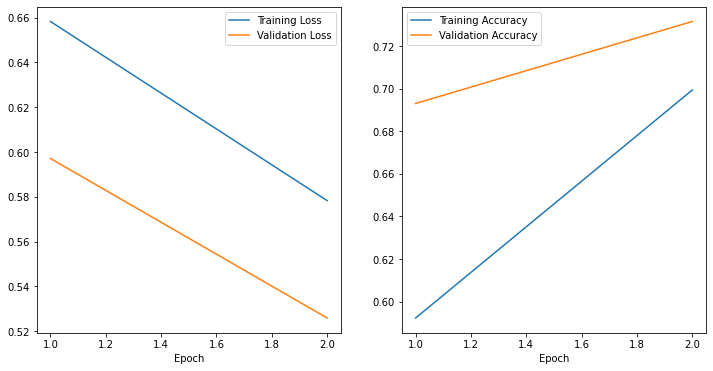

In [41]:
def vis_training(hlist, start=1):
    # This function will help to visualize the loss, val_loss, accuracy etc.

    # getting history of all kpi for each epochs
    loss = np.concatenate([hlist.history['loss']])
    val_loss = np.concatenate([hlist.history['val_loss']])
    acc = np.concatenate([hlist.history['accuracy']])
    val_acc = np.concatenate([hlist.history['val_accuracy']])
    epoch_range = range(1,len(loss)+1)

    # Block for training vs validation loss
    plt.figure(figsize=[12,6])
    plt.subplot(1,2,1)
    plt.plot(epoch_range[start-1:], loss[start-1:], label='Training Loss')
    plt.plot(epoch_range[start-1:], val_loss[start-1:], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.legend()
    # Block for training vs validation accuracy
    plt.subplot(1,2,2)
    plt.plot(epoch_range[start-1:], acc[start-1:], label='Training Accuracy')
    plt.plot(epoch_range[start-1:], val_acc[start-1:], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig('./output/graph/' +'train_log_local.png')
    
vis_training(train_model, start=1)

In [40]:
print(graph_path)

None


### Training model on EC2

Given the code above and knowledge from previous week, your task is to write a python script to train the model on EC2 instance. For this reason, I won't provide dogscats_CNN_tf2_nb.py.

In [8]:
prefix = "dogscats"
tensorflow_logs_path = "s3://{}/{}/logs".format(bucket, prefix)
training_input_path = "s3://{}/{}/input/train/".format(bucket, prefix)
validation_input_path = "s3://{}/{}/input/val/".format(bucket, prefix)
output_path = "s3://{}/{}/output".format(bucket, prefix)


print("SageMaker ver: " + sagemaker.__version__)

print("Bucket: {}".format(bucket))
print("Logs path: " + tensorflow_logs_path)
print("Training data location: " + training_input_path)
print("Validation data location: " + validation_input_path)
print("Output path: " + output_path)
print(role)

SageMaker ver: 2.109.0
Bucket: sagemaker-us-east-2-920448009623
Logs path: s3://sagemaker-us-east-2-920448009623/dogscats/logs
Training data location: s3://sagemaker-us-east-2-920448009623/dogscats/input/train/
Validation data location: s3://sagemaker-us-east-2-920448009623/dogscats/input/val/
Output path: s3://sagemaker-us-east-2-920448009623/dogscats/output
arn:aws:iam::920448009623:role/service-role/AmazonSageMaker-ExecutionRole-20220128T131204


In [45]:
# define the metrics to be sent to CloudWatch
metric_definitions = [
    {'Name': 'training_loss',        'Regex': 'loss: ([0-9\\.]+)'},
    {'Name': 'training_accuracy',    'Regex': 'accuracy: ([0-9\\.]+)'},
    {'Name': 'validation_loss',      'Regex': 'val_loss: ([0-9\\.]+)'},
    {'Name': 'validation_accuracy',  'Regex': 'val_accuracy: ([0-9\\.]+)'},
]

You might want to send a job to another EC2 for faster training. Some of the EC2 requires a request submission to AWS team. Keep in mind the cost and timeline for AWS to approve your EC2 request.

In [46]:

# configure the estimator
tf_estimator = TensorFlow(
    entry_point = 'dogscats_CNN_tf2_nb.py',
    base_job_name ='DogsCats-CNN',
    role = role,
    source_dir = '.',
    instance_count = 1,
    instance_type = 'ml.m4.xlarge',    
    framework_version = '2.1.0',
    py_version = 'py3',
    script_mode = True,
    hyperparameters = {'optimiser': 'SGD', 'tf-logs-path': tensorflow_logs_path,'epochs': 20},
    metric_definitions = metric_definitions,
    output_path = output_path)

# and give it a name
#training_job_name = 'Baseline-DogsCats'+ time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

In [47]:
# fit the model in SageMaker

tf_estimator.fit({'training': training_input_path,
          'validation': validation_input_path})

2022-09-22 02:32:38 Starting - Starting the training job...
2022-09-22 02:33:02 Starting - Preparing the instances for trainingProfilerReport-1663813958: InProgress
.........
2022-09-22 02:34:22 Downloading - Downloading input data..................
2022-09-22 02:37:22 Training - Training image download completed. Training in progress.2022-09-22 02:37:24,806 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2022-09-22 02:37:24,814 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-09-22 02:37:42,415 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-09-22 02:37:42,435 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-09-22 02:37:42,455 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-09-22 02:37:42,469 sagemaker-containers INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel

### Visualising metrics measures 

https://aws.amazon.com/blogs/machine-learning/easily-monitor-and-visualize-metrics-while-training-models-on-amazon-sagemaker/




- Option 1: Log into the [SageMaker console](https://console.aws.amazon.com/sagemaker/home), go to CloudWatch Dashboard metrics to view metrics of training jobs 

- Option 2:  Using Amazon SageMaker Python SDK APIs to visualize metrics

- Option 3: Save plots while training the model in the script file.

If you use option 3, it is good to understand some environment variables on SageMaker such as 

- **SM_MODEL_DIR**: A string representing the path to the directory to write model artifacts to. These artifacts are uploaded to S3 for model hosting.

- **SM_OUTPUT_DATA_DIR**: A string representing the filesystem path to write output artifacts to. Output artifacts may include checkpoints, graphs, and other files to save, not including model artifacts. These artifacts are compressed and uploaded to S3 to the same S3 prefix as the model artifacts

This would help us easily access various properties of training environment
References:

https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/using_sklearn.html
https://github.com/aws/sagemaker-training-toolkit/blob/master/ENVIRONMENT_VARIABLES.md

**Option 2**

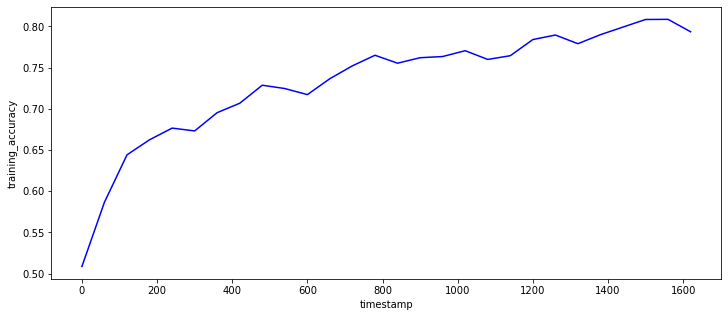

In [48]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics
from sagemaker.tuner import CategoricalParameter

training_job_name = 'DogsCats-CNN-2022-09-22-02-32-09-528'
metric_name = 'training_accuracy'

metrics_dataframe = TrainingJobAnalytics(training_job_name=training_job_name,metric_names=[metric_name]).dataframe()
plt = metrics_dataframe.plot(kind='line', figsize=(12,5), x='timestamp', y='value', style='b', legend=False)
plt.set_ylabel(metric_name);


**Option3**

You need to extract artifact output files to obtain png file. Here is how is done:

In [38]:
import boto3
os.makedirs("./output", exist_ok=True)
bucket_name = 'sagemaker-us-east-2-920448009623'
s3_file = 'dogscats/output/DogsCats-CNN-2022-09-22-02-32-09-528/output/output.tar.gz'
local_file = 'output/graph.tar.gz'
s3 = boto3.resource('s3')
s3.Bucket(bucket_name).download_file(s3_file, local_file)



In [39]:
!tar -xvf output/graph.tar.gz -C output

train_log.png


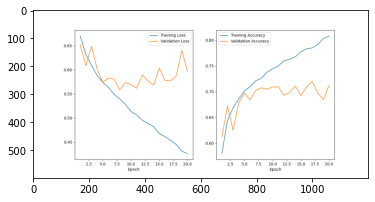

In [5]:
img = imread('output/train_log.png')
plt.imshow(img)


# Transfer learning


- Transfer learning uses models trained on a similar problem as a starting point for another related problem
- Transfer learning save training time for CNN.

**In this example**
 - We will hold the weights of all of the convolutional layers in VGG16 fixed during training, and only train new fully connected layers that are for image classification. 
 - We do that by loading the VGG-16 model, removing the fully connected layers from the output-end of the model, then adding the new fully connected layers to make a binary prediction. 
 - It will take approximately 20 minutes to run
 
 
**References**



- Keras provides an access to a number of CNN models via the Appliction API https://keras.io/api/applications/

Credit to https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/


In [1]:
import sagemaker 
print(sagemaker.__version__) 
sess = sagemaker.Session() 
role = sagemaker.get_execution_role() 

2.109.0


In [42]:
# vgg16 model used for transfer learning on the dogs and cats dataset
import sys
import os
import keras
import matplotlib.pyplot as plt
from tensorflow.keras import metrics
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
  

**Including a pricture of VGG16 structure here**

- The VGG16 model was trained on a ImageNet challenge dataset.


- The input images are 224 x 224 pixels (orginal pixels). **Here I reduced to 32x32 pixels for demonstration purpose**


1. **include_top**: whether to include the 3 fully-connected layers at the top of the network.
weights: one of None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded.

2. **input_shape**: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (32, 32, 3) (with channels_last data format) or (3, 32, 32) (with channels_first data format). It should have exactly 3 input channels, and width and height should be no smaller than 32. E.g. (200, 200, 3) would be one valid value.

3. **classes**: optional number of classes to classify images into, only to be specified if include_top is True, and if no weights argument is specified.

4. **classifier_activation**: A str or callable. The activation function to use on the "top" layer. Ignored unless include_top=True. Set classifier_activation=None to return the logits of the "top" layer. When loading pretrained weights, classifier_activation can only be None or "softmax".



More details are  https://keras.io/api/applications/

![VGG structure](VGG.png)

In [43]:

def define_model(img_rows,img_cols):
	# load model
	model = VGG16(include_top=False, # Leave out the last fully connected layer
                  input_shape=(img_rows,img_cols,3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flatten = Flatten()(model.output)
    # add a fully connected layer with 128 hidden units, ReLU activation and he_uniform initialisation
	dense = Dense(256, activation='relu', kernel_initializer='he_uniform')(flatten)
	output = Dense(1, activation='sigmoid')(dense)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	model.compile(optimizer=SGD(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
	return model



# Training
# define model
img_rows = 32
img_cols = 32
model = define_model(img_rows,img_cols)
# create data generator
datagen = ImageDataGenerator(featurewise_center=True)
# specify imagenet mean values for centering
datagen.mean = [123.68, 116.779, 103.939]
# prepare iterator

train_model = datagen.flow_from_directory('train/',class_mode='binary', target_size=(img_rows, img_cols))
test_model = datagen.flow_from_directory('val/',class_mode='binary', target_size=(img_rows, img_cols))
# fit model
history = model.fit(train_model, steps_per_epoch=len(train_model),validation_data=test_model, 
                    validation_steps=len(test_model), epochs=2, verbose=1)
# evaluate model
_, acc = model.evaluate_generator(test_model, steps=len(test_model), verbose=0)
print('> %.3f' % (acc * 100.0))
# learning curves



Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 719 steps, validate for 63 steps
Epoch 1/2
719/719 [==============================] - 224s 312ms/step - loss: 1.5921 - accuracy: 0.6626 - val_loss: 0.9569 - val_accuracy: 0.6860
Epoch 2/2
719/719 [==============================] - 221s 308ms/step - loss: 0.7395 - accuracy: 0.7057 - val_loss: 0.8175 - val_accuracy: 0.6710
  ...
    to  
  ['...']
> 67.100


In [44]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	plt.savefig('./output/graph/' +'VGG_CrossEntropy.png')

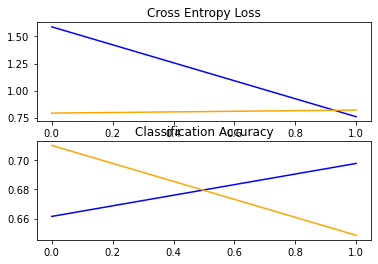

In [24]:
summarize_diagnostics(history)

Notice that the accuracy for a very simple and low pixels (32x32) is relatively good approximately 65%

In [ ]:
import boto3
sagemaker_client = boto3.client('sagemaker')
sagemaker_client.stop_notebook_instance(
        NotebookInstanceName='CNN-DogsCats')

### References
https://sagemaker-examples.readthedocs.io/en/latest/sagemaker-python-sdk/tensorboard_keras/tensorboard_keras.html


graph 

https://aws.amazon.com/blogs/machine-learning/easily-monitor-and-visualize-metrics-while-training-models-on-amazon-sagemaker/

**Homework**:
Use script mode for AWS training.